In [1]:
import requests

API_ROOT = 'http://api.nytimes.com/svc/search/v2/articlesearch.'

API_SIGNUP_PAGE = 'http://developer.nytimes.com/docs/reference/keys'

class NoAPIKeyException(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

class articleAPI(object):
    def __init__(self, key = None):
        """
        Initializes the articleAPI class with a developer key. Raises an exception if a key is not given.
        Request a key at http://developer.nytimes.com/docs/reference/keys
        :param key: New York Times Developer Key
        """
        self.key = key
        self.response_format = 'json'

        if self.key is None:
            raise NoAPIKeyException('Warning: Missing API Key. Please visit ' + API_SIGNUP_PAGE + ' to register for a key.')

    def _bool_encode(self, d):
        """
        Converts boolean values to lowercase strings
        """
        for k, v in d.items():
            if isinstance(v, bool):
                d[k] = str(v).lower()

        return d

    def _options(self, **kwargs):
        """
        Formats search parameters/values for use with API
        :param \*\*kwargs: search parameters/values
        """
        def _format_fq(d):
            for k,v in d.items():
                if isinstance(v, list):
                    d[k] = ' '.join(map(lambda x: '"' + x + '"', v))
                else:
                    d[k] = '"' + v + '"'
            values = []
            for k,v in d.items():
                value = '%s:(%s)' % (k,v)
                values.append(value)
            values = ' AND '.join(values)
            return values

        kwargs = self._bool_encode(kwargs)

        values = ''

        for k, v in kwargs.items():
            if k is 'fq' and isinstance(v, dict):
                v = _format_fq(v)
            elif isinstance(v, list):
                v = ','.join(v)
            values += '%s=%s&' % (k, v)

        return values

    def search(self,
                response_format = None,
                key = None,
                **kwargs):
        """
        Calls the API and returns a dictionary of the search results
        :param response_format: the format that the API uses for its response,
                                includes JSON (.json) and JSONP (.jsonp).
                                Defaults to '.json'.
        :param key: a developer key. Defaults to key given when the articleAPI class was initialized.
        """
        if response_format is None:
            response_format = self.response_format
        if key is None:
            key = self.key

        url = '%s%s?%sapi-key=%s' % (
            API_ROOT, response_format, self._options(**kwargs), key
        )

        self.req = requests.get(url)
        return self.req.json()

In [3]:
import pandas as pd

In [18]:
#from nytimesarticle import articleAPI
api = articleAPI('374962b0c0574a2ca78d0b7b9932babd')

In [19]:
#https://www.google.fr/search?ei=C1GcW-PtOISga-H6hKgD&q=top+news+stock+market+prices&oq=top+news+stock+market+prices&gs_l=psy-ab.3...1558.2845.0.3396.4.4.0.0.0.0.71.272.4.4.0....0...1c.1.64.psy-ab..0.0.0....0.a94ML33SEcs

articles = api.search( q = 'Dow Jones', 
     fq = {'headline':'Dow Jones', 'source':['MarketWatch','CNBC', 'economictimes','The New York Times']}, 
     begin_date = 20091231 )

In [21]:
def parse_articles(articles):
    
    news = []
    
    for i in articles['response']['docs']:
        
        dic = {}
        
        dic['headline'] = i['headline']['main'].encode("utf8")
        dic['date'] = i['pub_date'][0:10] # cutting time of day.
        #dic['section'] = i['section_name']
        if i['snippet'] is not None:
            dic['snippet'] = i['snippet'].encode("utf8")
        dic['source'] = i['source']
        dic['type'] = i['type_of_material']
        
        dic['url'] = i['web_url']
         # subject
        subjects = []
        for x in range(0,len(i['keywords'])):
            if 'subject' in i['keywords'][x]['name']:
                subjects.append(i['keywords'][x]['value'])
        dic['subjects'] = subjects  
        news.append(dic)
    return news

In [22]:
import time

def get_articles(start_year, query, end_year):
    
    all_articles = []
    year = start_year
    
    print('Retrieving articles URL...'),
    
    #Loop through all years of interest
    while year <= end_year:
        print(year)
        # Some pages might return a 'No JSON object could be decoded'
        # Example: country = Turkey, year = 1998, page 4
        # To keep this error from stopping the loop a try/except was used.

        for i in range(0,100): #NYT limits pager to first 100 pages. But rarely will you find over 100 pages of results anyway.
            articles = api.search(q = query,
            fq = {'source':['MarketWatch','CNBC', 'economictimes', 'The New York Times']},
                                  begin_date = str(year) + '0101',
                                  end_date = str(year) + '1231',
                                  sort='oldest',
                                  page = str(i))
            #if articles['response']['docs'] == []: break

            articles = parse_articles(articles)
            all_articles = all_articles + articles
                

            
            # Avoid overwhelming the API
            time.sleep(1)
            
        year += 1
    
    # Copy all articles on the list to a Pandas dataframe
    articles_df = pd.DataFrame(all_articles)
    
    # Make sure we filter out non-news articles and remove 'atype' column
    articles_df = articles_df.drop(articles_df[articles_df.type != 'News'].index)
    articles_df.drop('type', axis = 1, inplace = True)
    
    # Discard non-working links (their number of word_count is 0).
    # Example: http://www.nytimes.com/2001/11/06/world/4-die-during-police-raid-in-istanbul.html
    #articles_df = articles_df[articles_df.word_count != 0]
    #articles_df = articles_df.reset_index(drop = True)
    
    print('Done!')
    
    return(articles_df)

In [23]:
articles_all = get_articles(2010,'Dow Jones',2018)


Retrieving articles URL...
2010
2011
2012
2013
2014
2015
2016
2017
2018
Done!


In [24]:
articles_all_final = articles_all.drop_duplicates(subset='date', keep='first', inplace=False)

In [4]:
#articles_all_final.to_csv('articles_final.csv')
articles_all_final=pd.read_csv('articles_final.csv')

In [7]:
articles_all_final.tail(9)

,Unnamed: 0,date,headline,snippet,source,subjects,url
1992,3743,2018-07-26,b'Facebook\xe2\x80\x99s Stock Plunge Shatters ...,b'Roughly $120 billion in wealth was wiped out...,The New York Times,"['Social Media', 'Advertising and Marketing', ...",https://www.nytimes.com/2018/07/26/business/fa...
1993,3744,2018-08-01,b'Apple\xe2\x80\x99s Stock Buybacks Continue t...,b'The iPhone maker has repurchased almost $220...,The New York Times,['Stocks and Bonds'],https://www.nytimes.com/2018/08/01/business/de...
1994,3745,2018-08-02,b'Stocks Fall as Trade Tensions Cause Jitters',b'Benchmark stock indexes in Asia fell by more...,The New York Times,"['Stocks and Bonds', 'International Trade and ...",https://www.nytimes.com/2018/08/02/business/st...
1995,3746,2018-08-06,b'The Stock Market\xe2\x80\x99s Next $1 Trilli...,b'Corporate boards could authorize companies t...,The New York Times,"['Corporate Taxes', 'Stocks and Bonds', 'Board...",https://www.nytimes.com/2018/08/06/business/de...
1996,3748,2018-08-13,"b'Plunge in Lira, Turkey\xe2\x80\x99s Currency...",b'The country\xe2\x80\x99s economic crisis has...,The New York Times,"['Economic Conditions and Trends', 'Internatio...",https://www.nytimes.com/2018/08/13/business/tu...
1997,3749,2018-08-17,"b'As Stock Markets Brush Off Trade Tensions, a...",b'Copper\xe2\x80\x99s broad use in cyclical in...,The New York Times,"['International Trade and World Market', 'Stoc...",https://www.nytimes.com/2018/08/17/business/ch...
1998,3751,2018-09-03,b'Colin Kaepernick\xe2\x80\x99s Nike Campaign ...,"b'On the eve of the N.F.L. season, Nike, one o...",The New York Times,"['Football', 'National Anthems']",https://www.nytimes.com/2018/09/03/sports/kaep...
1999,3752,2018-09-06,b'An Inverted Jenny Surfaces. The Flawed Stamp...,b'No. 49 of 100 Jennies famously misprinted wi...,The New York Times,['Stamps (Postal)'],https://www.nytimes.com/2018/09/06/nyregion/in...
2000,3753,2018-09-11,b'Americans Want to Believe Jobs Are the Solut...,b'U.S. unemployment is down and jobs are going...,The New York Times,"['Poverty', 'Labor and Jobs', 'Wages and Salar...",https://www.nytimes.com/2018/09/11/magazine/am...


In [8]:

#download data from yahoo! finance
"""
data source: http://finance.yahoo.com/
"""


class YahooDailyReader():
    
    def __init__(self, symbol=None, start=None, end=None):
        import datetime, time
        self.symbol = symbol
        
        # initialize start/end dates if not provided
        if end is None:
            end = datetime.datetime.today()
        if start is None:
            start = datetime.datetime(2010,2,1)
        
        self.start = start
        self.end = end
        
        # convert dates to unix time strings
        unix_start = int(time.mktime(self.start.timetuple()))
        day_end = self.end.replace(hour=23, minute=59, second=59)
        unix_end = int(time.mktime(day_end.timetuple()))
        
        url = 'https://finance.yahoo.com/quote/{}/history?'
        url += 'period1={}&period2={}'
        url += '&filter=history'
        url += '&interval=1d'
        url += '&frequency=1d'
        self.url = url.format(self.symbol, unix_start, unix_end)
        
    def read(self):
        import requests, re, json
       
        r = requests.get(self.url)
        
        ptrn = r'root\.App\.main = (.*?);\n}\(this\)\);'
        txt = re.search(ptrn, r.text, re.DOTALL).group(1)
        jsn = json.loads(txt)
        df = pd.DataFrame(
                jsn['context']['dispatcher']['stores']
                ['HistoricalPriceStore']['prices']
                )
        df.insert(0, 'symbol', self.symbol)
        df['Date'] = pd.to_datetime(df['date'], unit='s').dt.date
        
        # drop rows that aren't prices
        df = df.dropna(subset=['close'])
        
        df = df[['Date', 'high', 'low', 'open', 'close', 
                 'volume', 'adjclose']]
        df = df.set_index('Date')
        df.index=pd.to_datetime(df.index)
        return df
    




In [12]:
data = YahooDailyReader('%5EDJI').read() #dowjones30
data = data.iloc[::-1]
data_final = data[['close']].copy()
# Adding new columns to the data frame
data_final["compound"] = ''
data_final["neg"] = ''
data_final["neu"] = ''
data_final["pos"] = ''


In [13]:
# Adding new columns to the data frame
data_final["compound"] = 0
data_final["neg"] = 0
data_final["neu"] = 0
data_final["pos"] = 0

In [11]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [14]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
sid = SentimentIntensityAnalyzer()
for date, row in articles_all_final.T.iteritems():
        #print(unicodedata.normalize('NFKD', articles_all_final.loc[date, 'headline']).encode('ascii','ignore'))
        sentence = (articles_all_final.loc[date, 'headline'])
        ss = sid.polarity_scores(str(sentence)[1:])
        Date = str(articles_all_final.loc[date, 'date'])
        data_final.loc[data_final.index == pd.to_datetime(Date), 'compound']= ss['compound']
        data_final.loc[data_final.index == pd.to_datetime(Date), 'neg']= ss['neg']
        data_final.loc[data_final.index == pd.to_datetime(Date), 'neu']= ss['neu']
        data_final.loc[data_final.index == pd.to_datetime(Date), 'pos']= ss['pos']
        #print (articles_all_final.loc[date, 'headline'])
        #print (date)

In [20]:
data_final.tail(36)

,close,compound,neg,neu,pos
Date,,,,,
2018-07-26,25527.070312,0.4215,0.000,0.741,0.259
2018-07-27,25451.060547,0.0000,0.000,0.000,0.000
2018-07-30,25306.830078,0.0000,0.000,0.000,0.000
2018-07-31,25415.189453,0.0000,0.000,0.000,0.000
2018-08-01,25333.820312,0.0000,0.000,1.000,0.000
2018-08-02,25326.160156,-0.4019,0.310,0.690,0.000
2018-08-03,25462.580078,0.0000,0.000,0.000,0.000
2018-08-06,25502.179688,0.0000,0.000,1.000,0.000
2018-08-07,25628.910156,0.0000,0.000,0.000,0.000


In [12]:
def load_stock(df, lookback=25):
    ''' scale data and split into training/test sets '''
    data = df.values
    n_train = list(df.index).index(df.index[-1]+timedelta(-365))
    scaler = preprocessing.StandardScaler() #normalize mean-zero, unit-variance
    scaler.fit(data[:n_train,:])
    data = scaler.transform(data)
    dataX, dataY = [], []
    for timepoint in range(data.shape[0]-lookback):
        dataX.append(data[timepoint:timepoint+lookback,:])
        dataY.append(data[timepoint+lookback,0])
    X_train, X_test = dataX[:n_train], dataX[n_train:]
    y_train, y_test = dataY[:n_train], dataY[n_train:]
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# load practice stock, AAPL
lookback = 25
X_train, y_train, X_test, y_test, scaler = load_stock(df=data_final, lookback=lookback)

1919 training examples, 228 test examples


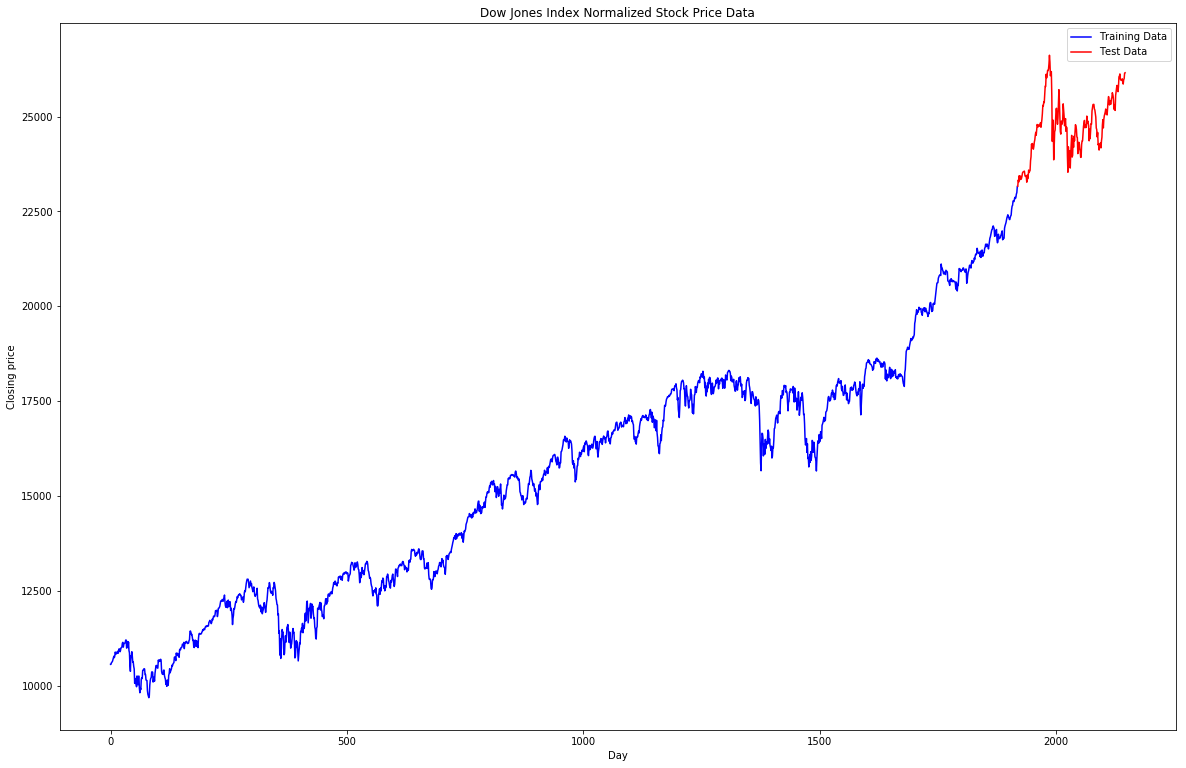

In [17]:
# denormalize training and test price data and plot
print ("%i training examples, %i test examples" % (len(y_train), len(y_test)))


#f,a = simple_ax(figsize=(10,6))
plt.plot(range(len(y_train)), inv_train, c='b', label='Training Data')
plt.plot(range(len(y_train),len(y_test)+len(y_train)), inv_test, c='r', label='Test Data')
plt.title('Dow Jones Index Normalized Stock Price Data')
plt.xlabel('Day')
plt.ylabel('Closing price')
plt.rcParams['figure.figsize']=(20,13)

plt.legend()
plt.show()

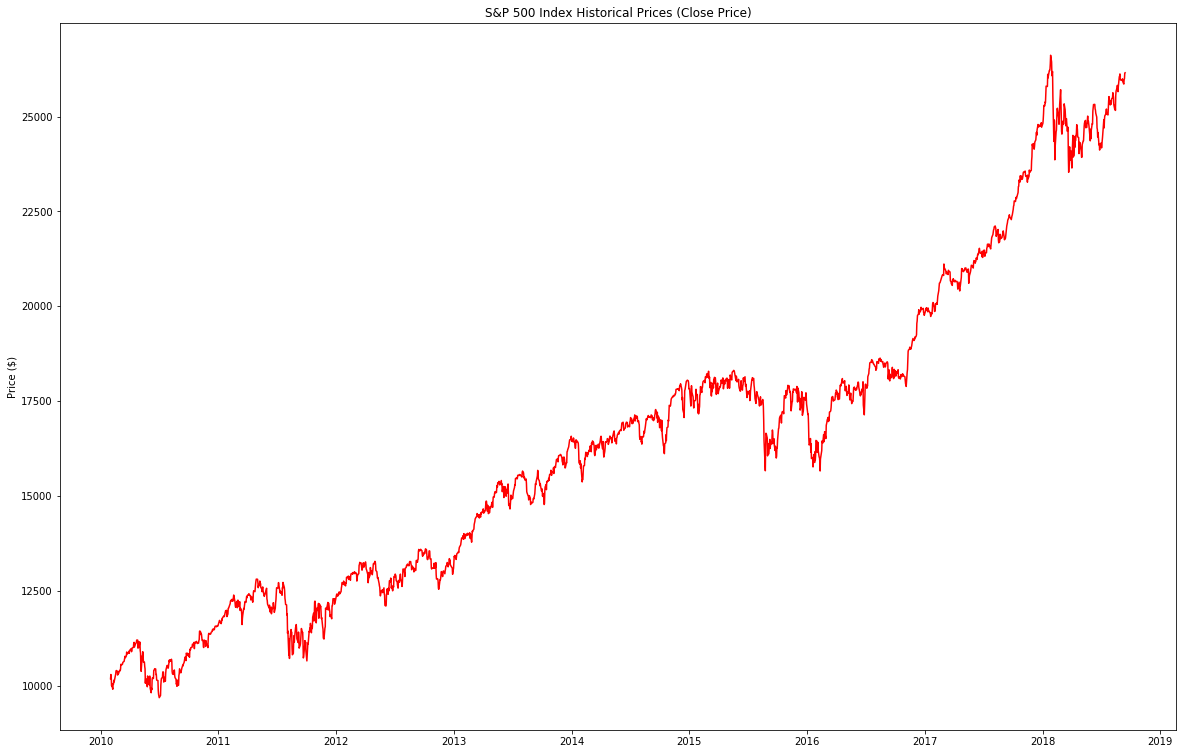

,high,low,open,close,volume,adjclose
Date,,,,,,
2018-09-13,26191.640625,26067.080078,26083.939453,26145.990234,260800000,26145.990234
2018-09-14,26211.109375,26068.289062,26169.560547,26154.669922,228640000,26154.669922


In [11]:
# The adjusted close accounts for stock splits, so that is what we should graph

plt.plot(data_final.index, data_final.close, 'r')
plt.title('S&P 500 Index Historical Prices (Close Price)')
plt.ylabel('Price ($)');

plt.rcParams['figure.figsize']=(20,13)

plt.show();
(data.tail(2))

In [11]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from sklearn import preprocessing
from datetime import datetime, timedelta
import time
from collections import Counter
import os
os.chdir('..')
%matplotlib inline

Using TensorFlow backend.


In [13]:
def inv_price_transform(normalized_data, scaler):
    ''' inverse from normalized price to raw price '''
    m = scaler.mean_[0]
    s = scaler.scale_[0]
    return s*np.array(normalized_data)+m

inv_train = inv_price_transform(y_train, scaler)
inv_test = inv_price_transform(y_test, scaler)

In [38]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

np.random.seed(7)
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True,stateful=False))
model.add(Dropout(0.3))

model.add(LSTM(64, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True,stateful=False))
model.add(Dropout(0.3))

model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=False,stateful=False))
model.add(Dropout(0.3))

model.add(Dense(1))
model.add(Activation('linear')) #linear output so we can have range of real-valued outputs


model.compile(loss='mean_squared_error', optimizer='Nadam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 25, 64)            17920     
_________________________________________________________________
dropout_14 (Dropout)         (None, 25, 64)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 25, 64)            33024     
_________________________________________________________________
dropout_15 (Dropout)         (None, 25, 64)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
__________

In [1]:
# fit model
t0 = time.time()
history = model.fit(
            X_train,
            y_train,
            batch_size=512,
            epochs=200,
            validation_split=0.05,
            verbose=0)
print ("TRAINING DONE. %i seconds to train." % int(time.time()-t0))

In [2]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.rcParams['figure.figsize']=(20,13)
#plt.ylim((0,0.02))

plt.show()

In [3]:
##### SAVE MODEL #####
'''
model0 : 12/3/2017 (incomplete data)
model1 : 12/4/2017 (complete dataset)
'''
model.save('model/model10.h5')

In [ ]:
#### LOAD MODEL #####
model = load_model('model/model0.h5')

In [22]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = inv_price_transform(trainPredict,scaler)
y_train = inv_price_transform(y_train,scaler)
testPredict = inv_price_transform(testPredict,scaler)
y_test = inv_price_transform(y_test,scaler)

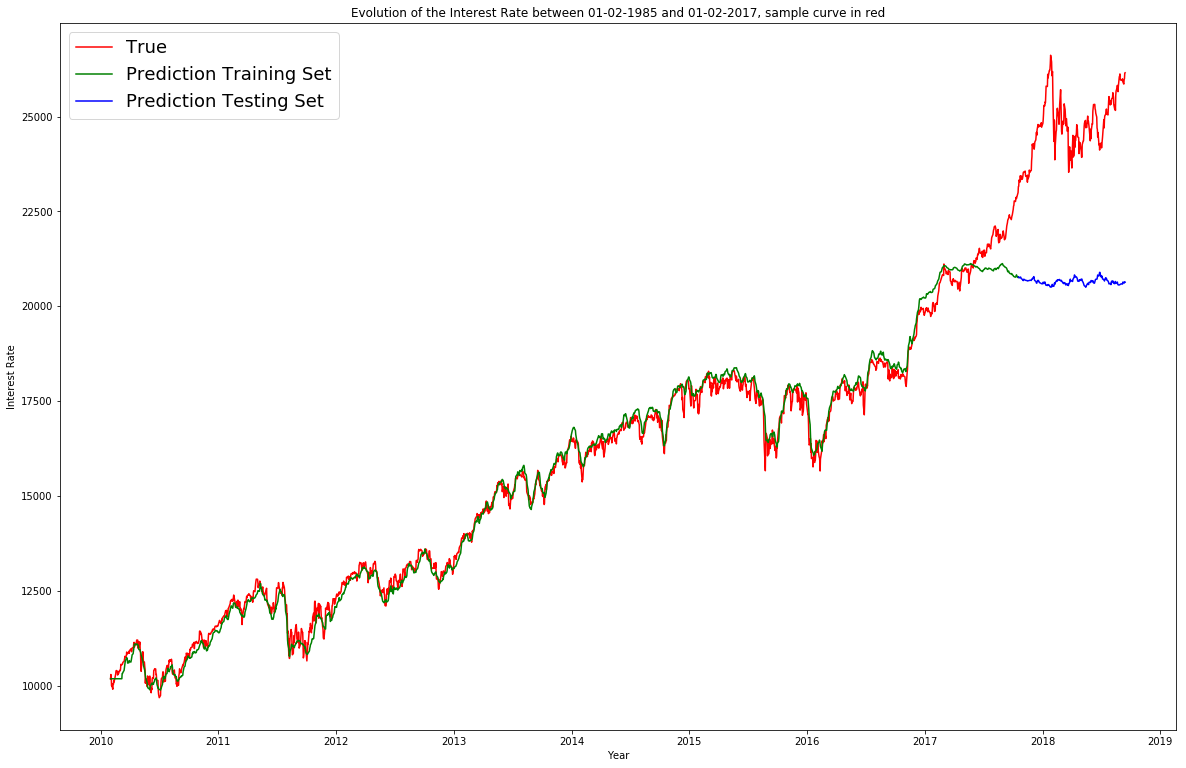

Train Score: 328.06 RMSE
Test Score: 4200.12 RMSE


In [28]:
import math
from sklearn.metrics import mean_squared_error


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))

testScore = math.sqrt(mean_squared_error(y_test, testPredict))


# shift train predictions for plotting

#df['Adj. Close']=scaler.inverse_transform(df.loc[:, 'Adj. Close'].reshape(-1,1))
data_final['Pred'] = data_final.loc[data_final.index[0], 'close']

data_final.loc[data_final.index[lookback:len(trainPredict)+lookback], 'Pred'] = trainPredict.reshape(len(trainPredict))
#faut toujours reshape 
data_final.loc[data_final.index[len(trainPredict)+lookback:], 'Pred'] = testPredict.reshape(len(testPredict))

# plot baseline and predictions
plt.plot(data_final['close'], 'r' , label = 'True')
plt.plot(data_final.loc[data_final.index[:len(trainPredict)+lookback], 'Pred'], 'g',label='Prediction Training Set')
plt.plot(data_final.loc[data_final.index[len(trainPredict)+lookback-1:], 'Pred'], 'b', label='Prediction Testing Set')
plt.legend(fontsize=18)

#la je met -1 a la place de 0 pour pouvoir recoller les graphes des prediction
plt.xlabel('Year')
plt.ylabel('Interest Rate')
plt.title('Evolution of the Interest Rate between 01-02-1985 and 01-02-2017, sample curve in red')
plt.show()

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))